<a href="https://colab.research.google.com/github/raizaduggal12/Ass4-Learning-Probability-Density-Functions/blob/main/Ass4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 0: IMPORT LIBRARIES
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import StandardScaler
from scipy.stats import gaussian_kde

import kagglehub

torch.manual_seed(42)
np.random.seed(42)

Transformation Parameters:
a_r = 0.0
b_r = 1.2
Using Colab cache for faster access to the 'india-air-quality-data' dataset.
Dataset downloaded at: /kaggle/input/india-air-quality-data
Using file: /kaggle/input/india-air-quality-data/data.csv

DATASET PREVIEW
  stn_code       sampling_date           state   location agency  \
0      150  February - M021990  Andhra Pradesh  Hyderabad    NaN   
1      151  February - M021990  Andhra Pradesh  Hyderabad    NaN   
2      152  February - M021990  Andhra Pradesh  Hyderabad    NaN   
3      150     March - M031990  Andhra Pradesh  Hyderabad    NaN   
4      151     March - M031990  Andhra Pradesh  Hyderabad    NaN   

                                 type  so2   no2  rspm  spm  \
0  Residential, Rural and other Areas  4.8  17.4   NaN  NaN   
1                     Industrial Area  3.1   7.0   NaN  NaN   
2  Residential, Rural and other Areas  6.2  28.5   NaN  NaN   
3  Residential, Rural and other Areas  6.3  14.7   NaN  NaN   
4                

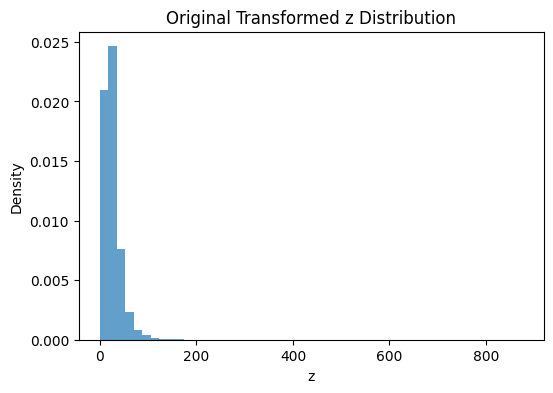

In [22]:
# STEP 1: DATA TRANSFORMATION

# UNIVERSITY ROLL NUMBER
r = 102303068

a_r = 0.5 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print("=================================")
print("Transformation Parameters:")
print("a_r =", a_r)
print("b_r =", b_r)
print("=================================")

# Download Dataset from Kaggle
path = kagglehub.dataset_download("shrutibhargava94/india-air-quality-data")
print("Dataset downloaded at:", path)

# Find CSV file
csv_files = [file for file in os.listdir(path) if file.endswith(".csv")]
file_path = os.path.join(path, csv_files[0])
print("Using file:", file_path)

# Read dataset
df = pd.read_csv(file_path, encoding='latin1', low_memory=False)

print("\n==============================")
print("DATASET PREVIEW")
print("==============================")
print(df.head())
print("\nDataset Shape:", df.shape)
print("\nColumns:\n", df.columns)

# Automatically detect NO2 column
no2_column = None
for col in df.columns:
    if "no2" in col.lower():
        no2_column = col
        break

if no2_column is None:
    raise ValueError("NO2 column not found! Please check dataset column names.")

print("\nUsing NO2 column:", no2_column)

# Convert to numeric safely
df[no2_column] = pd.to_numeric(df[no2_column], errors='coerce')
x = df[no2_column].dropna().values

print("\nTotal valid NO2 samples:", len(x))
print("\nBasic Statistics of NO2:")
print(pd.Series(x).describe())

# Apply transformation
# z = x + a_r sin(b_r x)
z = x + a_r * np.sin(b_r * x)

# Plot ORIGINAL TRANSFORMED z distribution
plt.figure(figsize=(6,4))
plt.hist(z, bins=50, density=True, alpha=0.7)
plt.title("Original Transformed z Distribution")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()

# Normalize for stable GAN training
z = z.reshape(-1, 1)

scaler = StandardScaler()
z_scaled = scaler.fit_transform(z)

real_data = torch.tensor(z_scaled, dtype=torch.float32)

In [ ]:
# STEP 2: GAN IMPLEMENTATION

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(10, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(1, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

G = Generator()
D = Discriminator()

criterion = nn.BCELoss()

optimizer_G = optim.Adam(G.parameters(), lr=0.0003)
optimizer_D = optim.Adam(D.parameters(), lr=0.0003)

epochs = 2000
batch_size = 256

print("\nStarting GAN Training...\n")

# TRAINING LOOP
for epoch in range(epochs):

    idx = np.random.randint(0, real_data.shape[0], batch_size)
    real_batch = real_data[idx]

    real_labels = torch.ones(batch_size, 1)
    fake_labels = torch.zeros(batch_size, 1)

    # Train Discriminator
    noise = torch.randn(batch_size, 10)
    fake_data = G(noise)

    loss_real = criterion(D(real_batch), real_labels)
    loss_fake = criterion(D(fake_data.detach()), fake_labels)
    loss_D = loss_real + loss_fake

    optimizer_D.zero_grad()
    loss_D.backward()
    optimizer_D.step()

    # Train Generator
    noise = torch.randn(batch_size, 10)
    fake_data = G(noise)

    loss_G = criterion(D(fake_data), real_labels)

    optimizer_G.zero_grad()
    loss_G.backward()
    optimizer_G.step()

    if epoch % 200 == 0:
        print(f"Epoch {epoch} | D Loss: {loss_D.item():.4f} | G Loss: {loss_G.item():.4f}")

print("\nTraining Completed!")


Starting GAN Training...

Epoch 0 | D Loss: 1.3777 | G Loss: 0.6000
Epoch 200 | D Loss: 1.4368 | G Loss: 0.6896
Epoch 400 | D Loss: 1.2861 | G Loss: 0.8317
Epoch 600 | D Loss: 1.4681 | G Loss: 0.6477
Epoch 800 | D Loss: 1.4236 | G Loss: 0.6487
Epoch 1000 | D Loss: 1.2731 | G Loss: 0.7564
Epoch 1200 | D Loss: 1.5238 | G Loss: 0.6149
Epoch 1400 | D Loss: 1.4685 | G Loss: 0.6282
Epoch 1600 | D Loss: 1.3320 | G Loss: 0.7548
Epoch 1800 | D Loss: 1.3388 | G Loss: 0.7174

Training Completed!


In [27]:
# FINAL SUBMISSION SUMMARY
print("FINAL SUBMISSION DETAILS")
print("a_r =", a_r)
print("b_r =", b_r)
print("\nGenerator Architecture:")
print("Input(10) → 64 → 32 → 1 (ReLU)")
print("\nDiscriminator Architecture:")
print("Input(1) → 32 → 16 → 1 (LeakyReLU + Sigmoid)")

FINAL SUBMISSION DETAILS
a_r = 0.0
b_r = 1.2

Generator Architecture:
Input(10) → 64 → 32 → 1 (ReLU)

Discriminator Architecture:
Input(1) → 32 → 16 → 1 (LeakyReLU + Sigmoid)


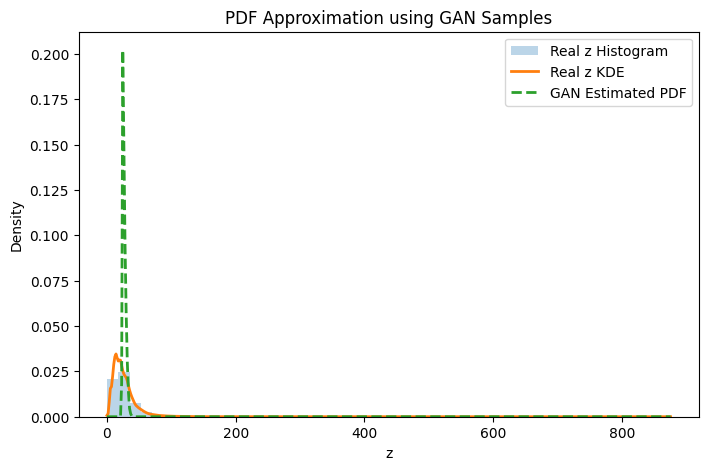

In [26]:
# STEP 3: PDF ESTIMATION

# Generate samples from Generator
noise = torch.randn(10000, 10)
generated = G(noise).detach().numpy()

# Inverse scaling to original z scale
generated = scaler.inverse_transform(generated)
real_original = scaler.inverse_transform(real_data.numpy())

# Flatten arrays
generated_flat = generated.flatten()
real_flat = real_original.flatten()

# Use SAME plotting range
x_min = min(real_flat.min(), generated_flat.min())
x_max = max(real_flat.max(), generated_flat.max())

x_vals = np.linspace(x_min, x_max, 500)

# KDE for both real and generated
kde_real = gaussian_kde(real_flat)
kde_generated = gaussian_kde(generated_flat)

pdf_real = kde_real(x_vals)
pdf_generated = kde_generated(x_vals)

# Plot everything consistently
plt.figure(figsize=(8,5))

# Real z histogram (same range)
plt.hist(real_flat, bins=50, range=(x_min, x_max),
         density=True, alpha=0.3, label="Real z Histogram")

# Real z KDE
plt.plot(x_vals, pdf_real, linewidth=2, label="Real z KDE")

# GAN KDE
plt.plot(x_vals, pdf_generated, linewidth=2, linestyle='--',
         label="GAN Estimated PDF")

plt.legend()
plt.title("PDF Approximation using GAN Samples")
plt.xlabel("z")
plt.ylabel("Density")
plt.show()